<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/XAI_loan_prediction_Random_Forest_Using_SMOTE_Rana_CLEANED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os
from imblearn.over_sampling import SMOTE

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Set random seed
random_seed = 42
np.random.seed(random_seed)

In [ ]:
# Create output directory
os.makedirs('model_outputs_rf', exist_ok=True)

Load and Prepare Data

In [ ]:
print("\nLoading preprocessed data...")
df = pd.read_csv('final_loan_data_leakproof.csv')
print("Dataset shape:", df.shape)
print("Columns in dataset:", df.columns.tolist())


Loading preprocessed data...
Dataset shape: (50000, 31)
Columns in dataset: ['loan_amnt', 'installment', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'issue_d_year', 'issue_d_month', 'earliest_cr_line_year', 'earliest_cr_line_month', 'int_rate_grade', 'loan_to_income', 'dti_ratio', 'credit_history_years', 'income_bin', 'term_ 60 months', 'emp_length_10+ years', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_debt_consolidation', 'target']


In [ ]:
# Separate features and target
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    le = LabelEncoder()
    for col in cat_cols:
        X[col] = le.fit_transform(X[col].astype(str))
    print(f"Encoded {len(cat_cols)} categorical columns.")

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (40000, 30)
Testing set shape: (10000, 30)


In [ ]:
# Reset indices
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

In [ ]:
# Apply SMOTE to balance training set
print("\nApplying SMOTE to balance training set...")
smote = SMOTE(random_state=random_seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced training set shape:", X_train_balanced.shape)
print("Class distribution after SMOTE:", y_train_balanced.value_counts().to_dict())


Applying SMOTE to balance training set...
Balanced training set shape: (63814, 30)
Class distribution after SMOTE: {0: 31907, 1: 31907}


In [ ]:
# Convert to numpy arrays
X_test_np = X_test.values
X_train_np = X_train_balanced.values
y_train_np = y_train_balanced.values

Model Building and Training

In [ ]:
# Create pipeline with scaler and Random Forest classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=random_seed))
])

In [ ]:
# Parameter grid for GridSearchCV
param_grid = {
    'model__max_depth': [10, None],
    'model__min_samples_split': [2]
}

In [ ]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_np, y_train_np)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, None],
                         'model__min_samples_split': [2]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Best model
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['model']
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

# Save model
with open('model_outputs_rf/randomforest_pipeline.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)
print("Pipeline saved as 'model_outputs_rf/randomforest_pipeline.pkl'")

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2}
Best ROC-AUC score: 0.9299045696813156
Pipeline saved as 'model_outputs_rf/randomforest_pipeline.pkl'


Model Evaluation

In [ ]:
# Predict probabilities and adjust threshold
threshold = 0.5
y_pred_proba = best_pipeline.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

In [ ]:
# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

# Print metrics
print("\nModel Performance Metrics (threshold = 0.5):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance Metrics (threshold = 0.5):
Accuracy: 0.7890
Precision: 0.4485
Recall: 0.1873
F1-Score: 0.2643
ROC-AUC: 0.6974


**Observation**
- The model, with a threshold of 0.5, achieves an accuracy of 0.7890 and an ROC-AUC of 0.6974, but its low recall (0.1873) and F1-score (0.2643) indicate poor performance in identifying positive cases, despite a moderate precision of 0.4485.

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      7977
           1       0.45      0.19      0.26      2023

    accuracy                           0.79     10000
   macro avg       0.63      0.56      0.57     10000
weighted avg       0.75      0.79      0.75     10000



<Figure size 800x600 with 0 Axes>

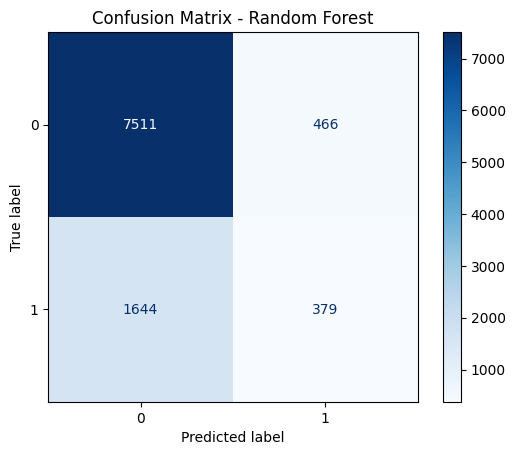

Confusion matrix saved as 'model_outputs_rf/confusion_matrix.png'


In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('model_outputs_rf/confusion_matrix.png')
plt.show()
plt.close()
print("Confusion matrix saved as 'model_outputs_rf/confusion_matrix.png'")

**Observation**
- The confusion matrix for the Random Forest model shows 7511 true negatives, 466 false positives, 1644 false negatives, and 379 true positives, indicating a high accuracy but a significant number of missed positive cases.

In [ ]:
# Save metrics
with open('model_outputs_rf/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")
print("Evaluation metrics saved as 'model_outputs_rf/evaluation_metrics.txt'")

Evaluation metrics saved as 'model_outputs_rf/evaluation_metrics.txt'


Explainability Techniques

SHAP Values

In [ ]:
# Use a small subset of test data for SHAP
X_test_sample = X_test.sample(n=100, random_state=random_seed)
X_test_sample_np = X_test_sample.values
# Use a background dataset for KernelExplainer
background_data = X_train_balanced.sample(n=50, random_state=random_seed)
# Define a prediction function for KernelExplainer (probability for positive class)
def predict_proba(X):
    return best_pipeline.predict_proba(X)[:, 1]
explainer = shap.KernelExplainer(predict_proba, background_data)
shap_values = explainer.shap_values(X_test_sample_np)

# Verify shapes
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"X_test_sample shape: {X_test_sample.shape}")

  0%|          | 0/100 [00:00<?, ?it/s]

SHAP values shape: (100, 30)
X_test_sample shape: (100, 30)


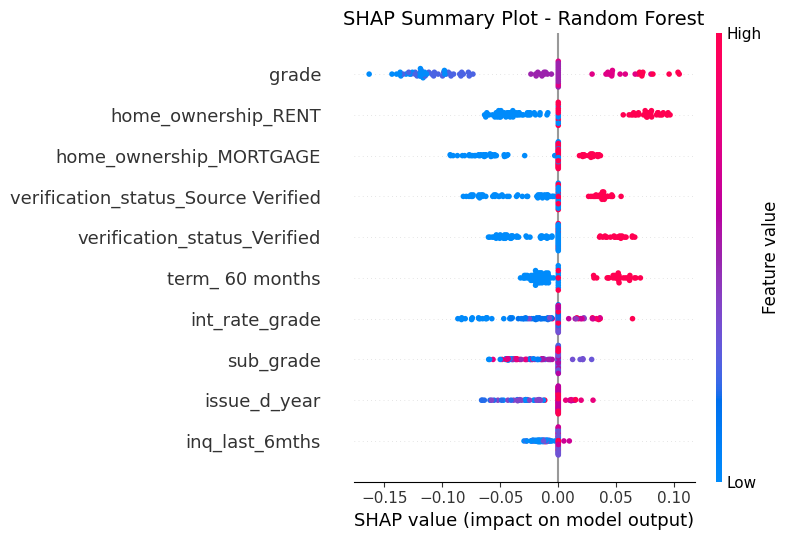

SHAP summary plot saved as 'model_outputs_rf/shap_summary.png'


In [ ]:
# SHAP Beeswarm Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, max_display=10, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - Random Forest", fontsize=14)
plt.tight_layout()
plt.savefig('model_outputs_rf/shap_summary.png')
plt.show()
plt.close()
print("SHAP summary plot saved as 'model_outputs_rf/shap_summary.png'")

Observation:

- The SHAP Summary Plot for the Random Forest model indicates that grade and sub_grade have the strongest impact on the model output, with positive SHAP values (red dots) showing higher feature values increase the prediction, while features like term_60_months and inq_last_6months have minimal influence.

Permutation Feature Importance

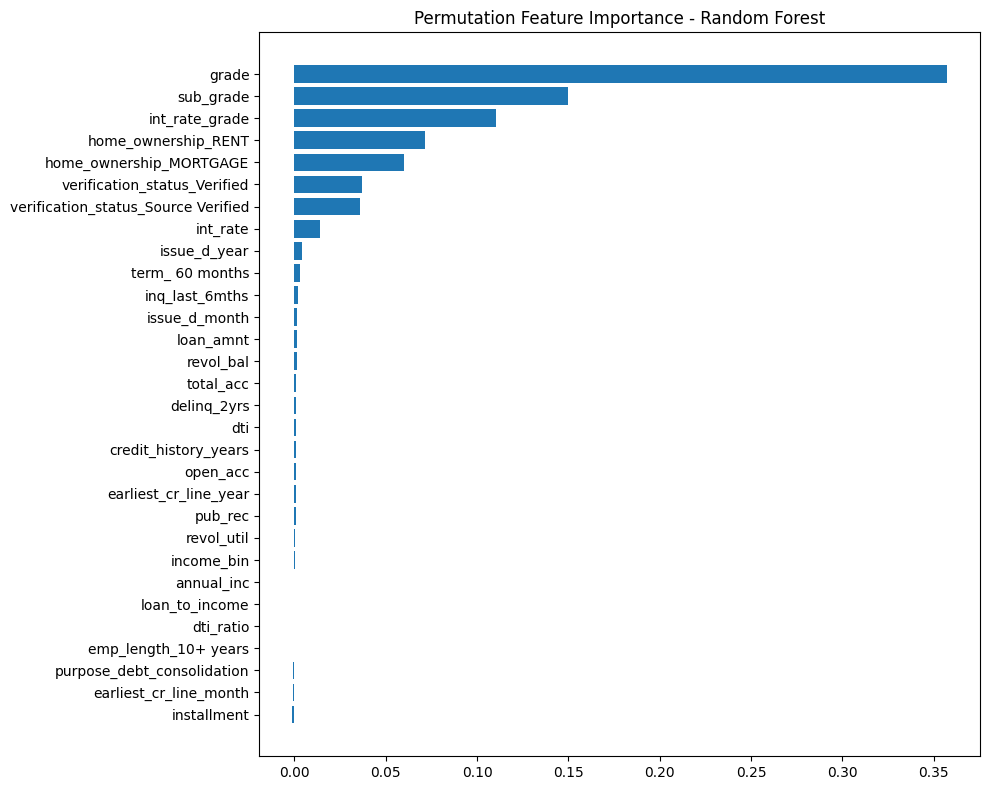

Permutation importance plot saved as 'model_outputs_rf/permutation_importance.png'


In [ ]:
perm_importance = permutation_importance(best_pipeline, X_test_np, y_test, n_repeats=5, random_state=random_seed)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title('Permutation Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('model_outputs_rf/permutation_importance.png')
plt.show()
plt.close()
print("Permutation importance plot saved as 'model_outputs_rf/permutation_importance.png'")

**Observation**
- The Permutation Feature Importance plot for the Random Forest model highlights sub_grade and grade as the most influential features, followed by int_rate_grade, home_ownership_RENT, and home_ownership_MORTGAGE, while other features like installment and annual_inc have minimal impact.

Global Surrogate Model

Surrogate Model R^2 Score: 0.6592


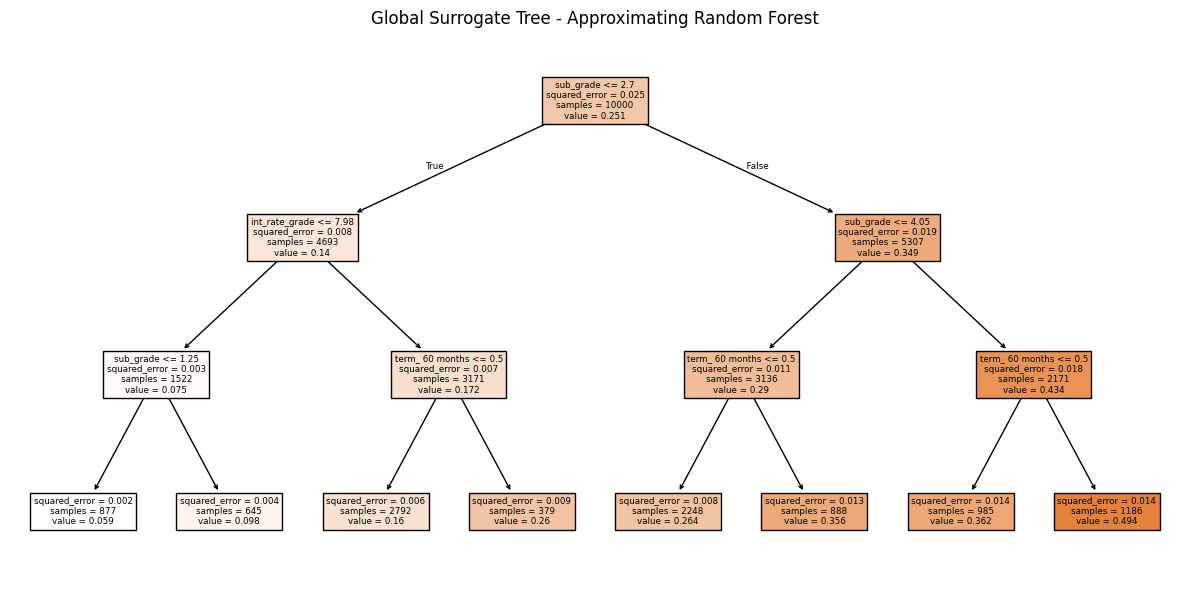

Surrogate decision tree visualization saved as 'model_outputs_rf/surrogate_decision_tree.png'


In [ ]:
y_pred_proba_surrogate = best_pipeline.predict_proba(X_test_np)[:, 1]
surrogate = DecisionTreeRegressor(max_depth=3, random_state=random_seed)
surrogate.fit(X_test, y_pred_proba_surrogate)

# Evaluate surrogate model
surrogate_r2 = surrogate.score(X_test, y_pred_proba_surrogate)
print(f"Surrogate Model R^2 Score: {surrogate_r2:.4f}")

# Plot the surrogate tree
plt.figure(figsize=(12, 6))
from sklearn import tree
tree.plot_tree(surrogate, feature_names=X_test.columns, filled=True)
plt.title("Global Surrogate Tree - Approximating Random Forest")
plt.tight_layout()
plt.savefig('model_outputs_rf/surrogate_decision_tree.png')
plt.show()
plt.close()
print("Surrogate decision tree visualization saved as 'model_outputs_rf/surrogate_decision_tree.png'")

**Observation**
- The Global Surrogate Tree approximating the Random Forest model splits primarily on sub_grade and term_60_months, with sub_grade < 4.05 and term_60_months < 0.05 leading to higher predicted values (e.g., 0.949), while other branches show lower values (e.g., 0.278), reflecting key decision boundaries in the model.

Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) for 'grade'

In [ ]:
# Find the index of the 'grade' feature
grade_index = X.columns.get_loc('grade')
print(f"Feature 'grade' found at index: {grade_index}")
# Transform X_test using the pipeline's scaler
X_test_scaled = best_pipeline.named_steps['scaler'].transform(X_test)

Feature 'grade' found at index: 3


<Figure size 1000x500 with 0 Axes>

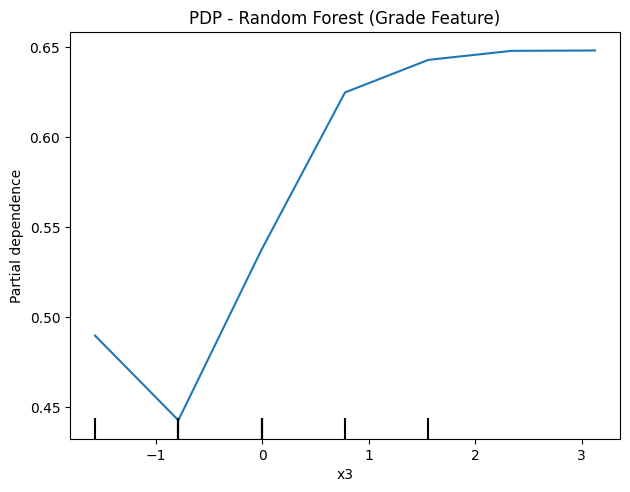

PDP plot for 'grade' saved as 'model_outputs_rf/pdp_grade.png'


In [ ]:
# PDP for 'grade'
plt.figure(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline.named_steps['model'],
    X_test_scaled,
    features=[grade_index],
    kind='average',
    grid_resolution=20
)
plt.tight_layout()
plt.title("PDP - Random Forest (Grade Feature)")
plt.savefig('model_outputs_rf/pdp_grade.png')
plt.show()
plt.close()
print("PDP plot for 'grade' saved as 'model_outputs_rf/pdp_grade.png'")

**Observation**
- The PDP for the Random Forest model (Grade Feature) shows that as x3
  increases from -1 to 3, the partial dependence steadily rises from around 0.50 to 0.65, indicating a consistent positive relationship between x3 and the target variable.

<Figure size 1000x500 with 0 Axes>

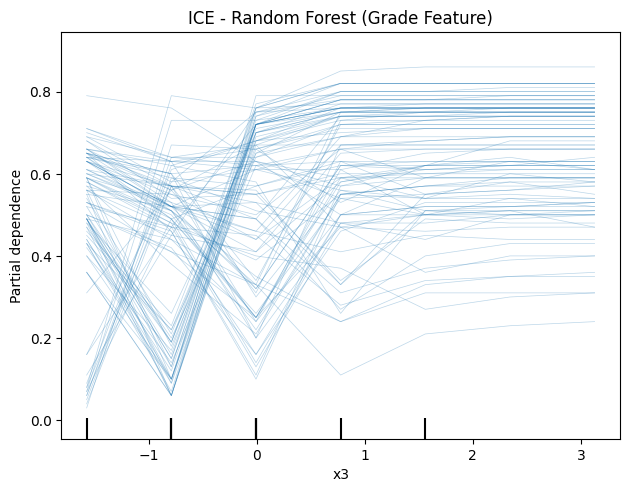

ICE plot for 'grade' saved as 'model_outputs_rf/ice_grade.png'


In [ ]:
# ICE for 'grade'
plt.figure(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    best_pipeline.named_steps['model'],
    X_test_scaled,
    features=[grade_index],
    kind='individual',
    grid_resolution=20,
    subsample=100  # Limit number of ICE lines for performance
)
plt.tight_layout()
plt.title("ICE - Random Forest (Grade Feature)")
plt.savefig('model_outputs_rf/ice_grade.png')
plt.show()
plt.close()
print("ICE plot for 'grade' saved as 'model_outputs_rf/ice_grade.png'")

**Observation:**
The ICE plot for the Random Forest model (Grade Feature) shows that as the feature x3
increases from -1 to 3, the partial dependence fluctuates, with a sharp rise around
x3=0, a dip near
x3=1, and then stabilizes, indicating varying influence of x3
on the target variable across different instances